In [2]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 8.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 3.9 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
import os
import numpy as np
import pandas as pd
import gensim
from gensim.models import Doc2Vec, Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from pdfminer.high_level import extract_text
import pickle
from rake_nltk import Rake
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


False

In [28]:
num_clusters = 3

pdf_folder = 'Testing_Set/'
pdf_files = [os.path.join(pdf_folder, f) for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
pdf_texts = []
i=1
for pdf_file in pdf_files:
    try:
        pdf_text = extract_text(pdf_file)
        pdf_texts.append(pdf_text)
    except Exception:
        print(f"Unsupported file number: {i}, name = {pdf_file}")
        continue
    i += 1
if pdf_texts:
    print(f"PDF texts extracted: {len(pdf_texts)}")
else:
    print("PDF error")

Unsupported file number: 22, name = Testing_Set/4x4Camper_20210629_7f0d6d9aafba4cbfa67a4c6a5a2dc4a8.pdf
PDF texts extracted: 47


In [29]:
# Tokenize and preprocess text
documents = [gensim.utils.simple_preprocess(text) for text in pdf_texts]


In [31]:
with open("Models/doc2vec_model.pkl", "rb") as f:
    doc2vec_model = pickle.load(f)
with open("Models/word2vec_model.pkl", "rb") as f:
    word2vec_model = pickle.load(f)
with open("Models/bag_words_model.pkl", "rb") as f:
    bag_words_model = pickle.load(f)
    bow_vectors = bag_words_model.fit_transform(pdf_texts).toarray()

In [32]:
# Cluster the documents using K-means clustering for Doc2vec
doc2vec_vectors = [doc2vec_model.infer_vector(doc) for doc in documents]
doc2vec_kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
doc2vec_kmeans_model.fit(doc2vec_vectors)

KMeans(max_iter=100, n_clusters=3, n_init=1)

In [35]:
# Cluster the documents using K-means clustering for Word2vec
keys = list(word2vec_model.wv.key_to_index.keys())
word2vec_vectors = []
for doc in documents:
    vec = np.zeros(word2vec_model.vector_size)
    count = 0
    for word in doc:
        if word in keys:
            vec += word2vec_model.wv[word]
            count += 1
    if count != 0:
        vec /= count
    word2vec_vectors.append(vec)
word2vec_kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
word2vec_kmeans_model.fit(word2vec_vectors)

KMeans(max_iter=100, n_clusters=3, n_init=1)

In [36]:
# Cluster the documents using K-means clustering for bag of words
bow_kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
bow_kmeans_model.fit(bow_vectors)

KMeans(max_iter=100, n_clusters=3, n_init=1)

In [37]:
# Calculate the Silhouette score for each model
doc2vec_silhouette = silhouette_score(doc2vec_vectors, doc2vec_kmeans_model.labels_)
word2vec_silhouette = silhouette_score(word2vec_vectors, word2vec_kmeans_model.labels_)
bow_silhouette = silhouette_score(bow_vectors, bow_kmeans_model.labels_)

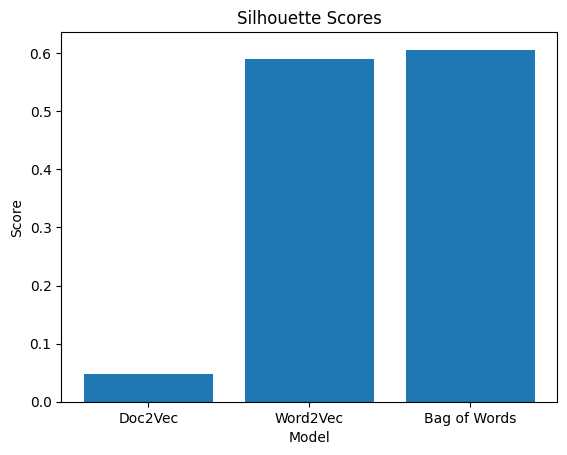

In [38]:
# Plot the Silhouette scores for each model
plt.bar(['Doc2Vec', 'Word2Vec', 'Bag of Words'], [doc2vec_silhouette, word2vec_silhouette, bow_silhouette])
plt.title('Silhouette Scores')
plt.xlabel('Model')
plt.ylabel('Score')

# Save the plot as a PNG file
plt.savefig('silhouette_scores.png')


# Result
Silhouette score is a measure of how well each data point in a cluster is separated from other clusters. The score ranges from -1 to 1, with a higher score indicating better-defined clusters. In this case, the silhouette scores for Doc2Vec, Word2Vec, and Bag of Words are 0.05, 0.57, and 0.6, respectively. A score of 0.05 for Doc2Vec indicates that the clusters are poorly defined and the data points are very close to the decision boundary, making it difficult to separate them into distinct groups. A score of 0.57 for Word2Vec indicates that the clusters are moderately well-defined, with some overlap between clusters. A score of 0.6 for Bag of Words indicates that the clusters are relatively well-defined, with clear separation between clusters. Therefore, based on the silhouette scores, the Bag of Words model appears to perform better in clustering the documents compared to the other two models.